In [3]:
import numpy as np
import glob
import os
from matplotlib import pyplot as pl

from mlp_backprop_momentum import MLP
import k_fold_cross_validation as cv

import scipy.io.wavfile as wav
from scikits.talkbox.features import mfcc
import MFCC_computation as util

reload(util)

%matplotlib inline

## MAN vs. CHILDREN

Here we use only the natural voices of men and children to train a neural network that recognizes the gender of the speaker.

## Preparing dataset
### Load and split files by classes

In [13]:
path = os.getcwd() + '/vowels'

VOWELS = glob.glob(path + '/*.wav')
assert len(VOWELS) > 0, ".wav files not found in " + path + " ! Please check the path"

FILES = {
    'natural_male': glob.glob(path + '/nam*.wav'),
    'natural_kid': glob.glob(path + '/nk*.wav')
}

# number of coefficients used
MFCC_COEFFS = 13

### MFCC Visualization

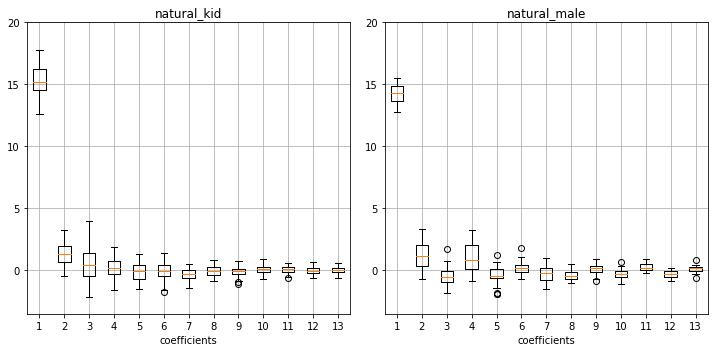

In [14]:
util.print_coeff_boxplot(['natural_male', 'natural_kid'], FILES)

### Model complexity and learning duration

In order to choose the correct learning duration and the modely complexity, we iterate over the number of epochs (`EPOCHS`) and number of hidden neurons (`N_NEURONS`).

testing 8 neurons...
testing 32 neurons...
testing 64 neurons...
Done


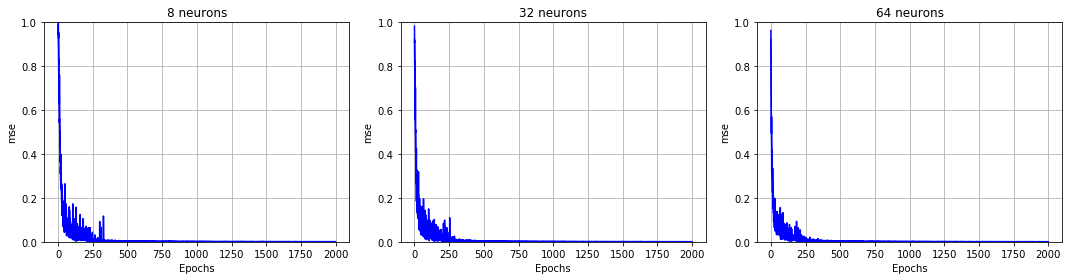

In [15]:
EPOCHS = 2000
N_NEURONS = [8, 32, 64]
LEARNING_RATE = 0.001
MOMENTUM = 0.7

K = 3

N_INITS = 2
dataset = util.create_dataset([('natural_male', -1), ('natural_kid', 1)], FILES)
dataset_input = dataset[:, :-1]     # filter only input values (n-1 first values)
dataset_output = dataset[:, -1:]    # filter only the output class (last value)

MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))
for index, n_neurons in enumerate(N_NEURONS):
    print 'testing', n_neurons, 'neurons...'
    nn = MLP([MFCC_COEFFS, n_neurons, 1], 'tanh')

    for i in np.arange(N_INITS):
        nn.init_weights()
        MSE[index, i, :] = nn.fit((dataset_input, dataset_output),
                                  learning_rate=LEARNING_RATE,
                                  momentum=MOMENTUM,
                                  epochs=EPOCHS)

util.print_mse(MSE, N_NEURONS)
print 'Done'

The results here are rather good. The number of epochs drastically reflects on them, compared to the number of neurons. However, although the mean squared error average is low for every neuron sample from 250-500 epochs onward, the different iterations get more similar results when the number of neurons is raised.

Testing 8 neurons...
Testing 32 neurons...
Testing 64 neurons...


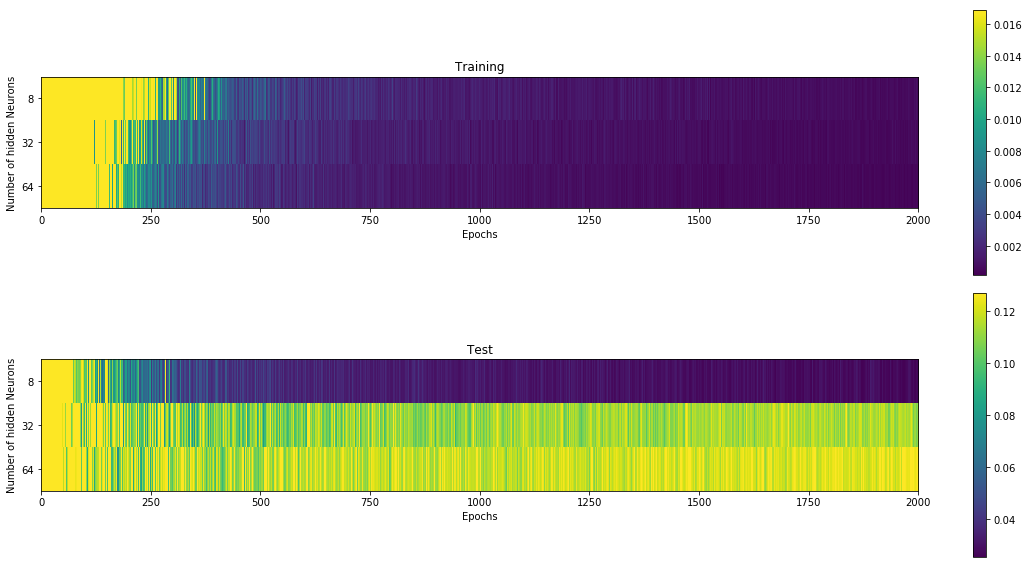

In [17]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))


dataset = util.create_dataset([('natural_male', -1), ('natural_kid', 1)], FILES)

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = MLP([MFCC_COEFFS, h, 1], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=MOMENTUM,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2


# print results
util.print_mse_train_test(MSE_train, MSE_test, N_NEURONS, aspect=100)

### Final Model and performance

In [27]:
EPOCHS = 2000
N_NEURONS = 64
LEARNING_RATE = 0.0005
MOMENTUM = 0.8
K = 3

precision:	0.986
recall:	0.986
f1_score:	0.986
MSE training:	0.000299017795708
MSE test:	0.0321576003235
Confusion matrix:
[[ 36.   0.]
 [  1.  35.]]


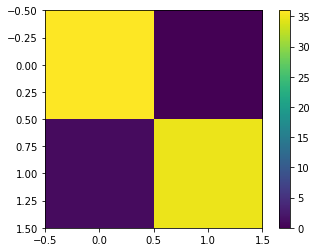

In [28]:
nn = MLP([MFCC_COEFFS, N_NEURONS, 1], 'tanh')
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                           dataset,
                                                           k=K,
                                                           learning_rate=LEARNING_RATE,
                                                           momentum=MOMENTUM,
                                                           epochs=EPOCHS,
                                                           threshold=0.0)


precision, recall, f1_score = util.conf_mat_stats(conf_mat)
print "precision:\t", np.round(precision, 3)
print "recall:\t",    np.round(recall, 3)
print "f1_score:\t",  np.round(f1_score, 3)
print 'MSE training:\t', MSE_train
print 'MSE test:\t', MSE_test
print 'Confusion matrix:'
pl.imshow(conf_mat)
pl.colorbar()
print conf_mat

Using a momentum value of 0.8, 2000 epochs, a learning rate of 0.0005 and 64 neurons:

The class 1 results are 36 correct estimates and 0 incorrect one. The class 2 results are 1 incorrent estimate and 35 correct ones.